In [1]:
import wolf
from workflow import dig_workflow
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Reading hg19, DIG formatted MAF file 

In [2]:
df = pd.read_csv('TCGA_WGS_UVM.validated.maf', sep='\t')

In [3]:
df['Tumor_Sample_Barcode']

0         TCGA-RZ-AB0B-01A
1         TCGA-RZ-AB0B-01A
2         TCGA-RZ-AB0B-01A
3         TCGA-RZ-AB0B-01A
4         TCGA-RZ-AB0B-01A
                ...       
159664    TCGA-YZ-A985-01A
159665    TCGA-YZ-A985-01A
159666    TCGA-YZ-A985-01A
159667    TCGA-YZ-A985-01A
159668    TCGA-YZ-A985-01A
Name: Tumor_Sample_Barcode, Length: 159669, dtype: object

# Mutation burden across samples within the cohort

TCGA-YZ-A985-01A: 26385 number of mutations


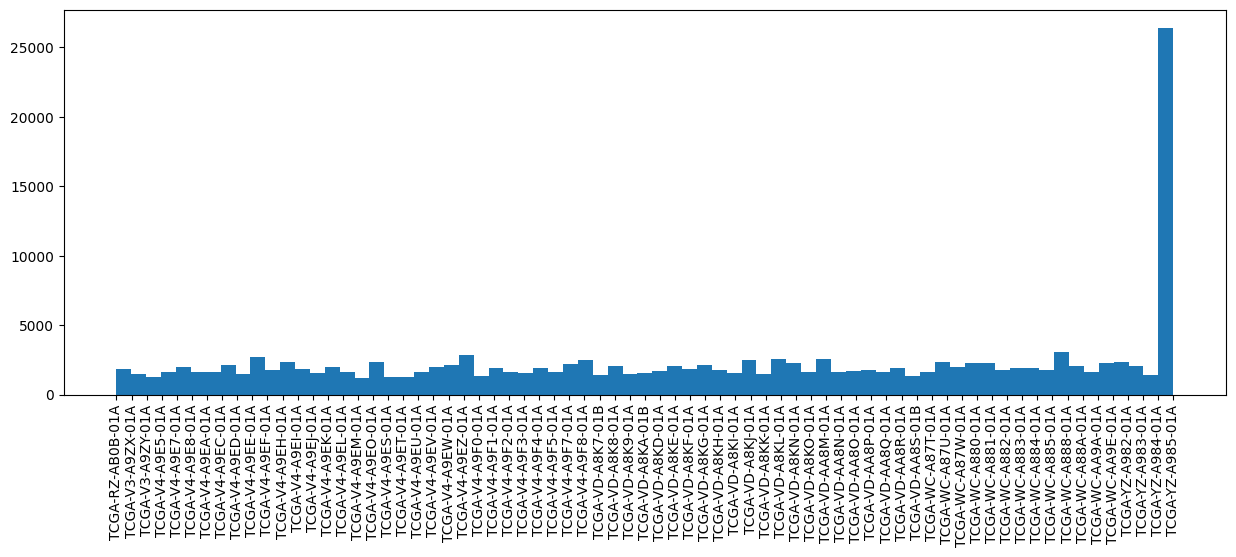

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
col_sids = 'Tumor_Sample_Barcode'
ax.hist(df[col_sids], bins=df[col_sids].unique().shape[0])
ax.tick_params(axis='x', labelrotation=90)
ids, cts = np.unique(df[col_sids], return_counts=True)
idx_max = np.argsort(cts)[-1]
print(ids[idx_max] + ': ' + str(cts[idx_max]) + ' number of mutations')
plt.show()

# Excluding outlier from training cohort

In [5]:
df = df.loc[~df[col_sids].isin([ids[idx_max]])]
df.to_csv('TCGA_WGS_UVM.maf', sep='\t')
df

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,...,dbSNP_VP,dbSNP_WGT,dbSNP_WTD,dbSNP_dbSNPBuildID,dbSNP_ID,dbSNP_FILTER,HGNC_Entrez_Gene_ID(supplied_by_NCBI),dbSNP_RSPOS,dbSNP_VLD,SOMATIC
0,TTLL10,254173.0,UNKNOWN,hg38,chr1,1171734,1171734,+,5'Flank,SNP,...,NaN,NaN,false,NaN,NaN,NaN,254173.0,NaN,false,True
1,LRRC47,57470.0,UNKNOWN,hg38,chr1,3801184,3801184,+,5'Flank,SNP,...,NaN,NaN,false,NaN,NaN,NaN,57470.0,NaN,false,True
2,Unknown,NaN,UNKNOWN,hg38,chr1,4881419,4881419,+,IGR,SNP,...,NaN,NaN,false,NaN,NaN,NaN,NaN,NaN,false,True
3,CAMTA1,23261.0,UNKNOWN,hg38,chr1,7487512,7487512,+,Intron,SNP,...,NaN,NaN,false,NaN,NaN,NaN,23261.0,NaN,false,True
4,PER3,8863.0,UNKNOWN,hg38,chr1,7798053,7798053,+,Intron,SNP,...,0x050000080005000002000100,1,false,151,rs1377387790,NaN,8863.0,7798053,false,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133279,Unknown,NaN,UNKNOWN,hg38,chrX,147314488,147314488,+,IGR,SNP,...,0x050000000005000002000100,1,false,151,rs1278307797,NaN,NaN,147314488,false,True
133280,AFF2,2334.0,UNKNOWN,hg38,chrX,148547207,148547207,+,Intron,SNP,...,0x050100080005000002000100,1,false,92,rs2016745,NaN,2334.0,148547207,false,True
133281,AF274853.1,NaN,UNKNOWN,hg38,chrX,151362837,151362837,+,RNA,SNP,...,0x050000000005000002000100,1,false,151,rs1336421296,NaN,NaN,151362837,false,True
133282,PASD1,139135.0,UNKNOWN,hg38,chrX,151665924,151665924,+,Intron,SNP,...,NaN,NaN,false,NaN,NaN,NaN,139135.0,NaN,false,True


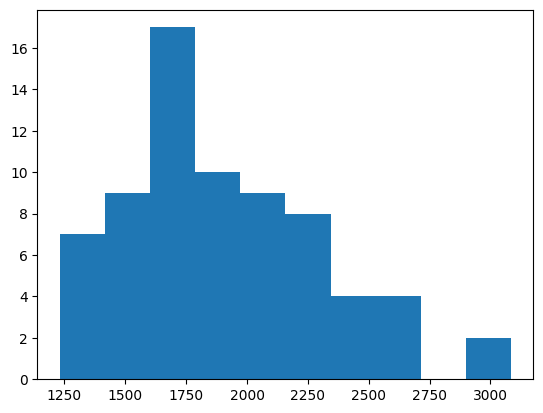

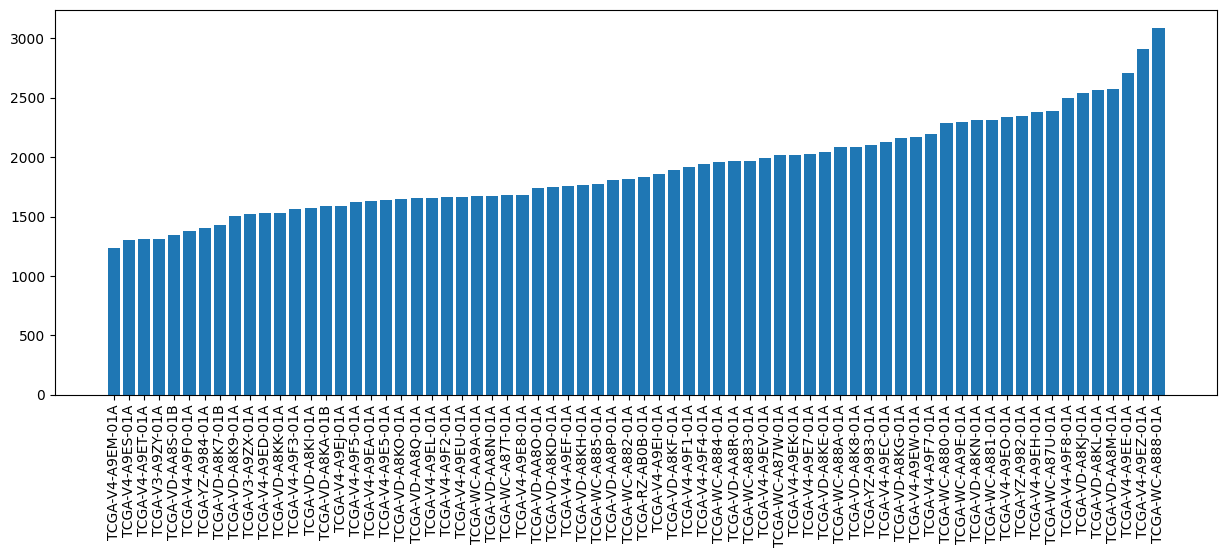

In [6]:
ids, cts = np.unique(df[col_sids], return_counts=True)
plt.hist(cts)
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ind_sorted = np.argsort(cts)
plt.bar(ids[ind_sorted], cts[ind_sorted])
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Running workflow for mutation map training

In [7]:
with wolf.Workflow(workflow = dig_workflow) as w:
    w.run(
        maf_file = 'TCGA_WGS_UVM.maf', # MAF from characterization pipeline        
        interval_set_name = [
            "promoters",
            "3-prime_UTRs",
            "5-prime_UTRs"
        ], # the first 3 interval sets must remain these, and in this order, additional sets can be added 
        interval_set_bed = [
            "gs://getzlab-workflows-reference_files-oa/hg38/dig/gc19_pc.prom.bed",
            "gs://getzlab-workflows-reference_files-oa/hg38/dig/gc19_pc.3utr.bed",
            "gs://getzlab-workflows-reference_files-oa/hg38/dig/gc19_pc.5utr.bed"
        ], # must be consistent with list above
        # mutation_map = "https://cb.csail.mit.edu/DIG/downloads/mutation_maps/Kidney-RCC_SNV_MNV_INDEL.Pretrained.h5", # mutation map trained for the analyzed cohort
        ref_build = "hg38", # reference genome for MAF file
        RUN_NAME = "DIG_burden_test"
    )           

[20241009-01:40:30] [prefect] Starting Slurm controller ...
[20241009-01:40:30] [prefect] Waiting up to 60 seconds for Slurm controller to start ...
[20241009-01:40:30] [prefect] Started Slurm controller.
[20241009-01:40:30] [prefect] Workflow results disk low on space (22 GB remaining)
[20241009-01:40:30] [prefect] Enqueued workflow DIG_burden_test
[20241009-01:40:30] [DIG_burden_test:DIG_convert_maf] Hashing file TCGA_WGS_UVM.maf; 100/190 MiB completed
[20241009-01:40:32] [DIG_burden_test:Localize_tracks] Job avoidance disabled for this task; overwriting output.
[20241009-01:40:32] [DIG_burden_test:Localize_tracks] Localizing inputs...
[20241009-01:40:32] [DIG_burden_test:DIG_convert_maf] Localizing inputs...
[20241009-01:40:32] [DIG_burden_test:DIG_convert_maf] Task staged in /mnt/nfs/workspace/DIG_burden_test/DIG_convert_maf__2024-10-08--14-33-09_mblxxey_s2nsq0q_cvilttyadla1u
[20241009-01:40:32] [DIG_burden_test:DIG_convert_maf] 1/1 jobs avoided
[20241009-01:40:32] [DIG_burden_test

Copying gs://getzlab-workflows-reference_files-oa/hg38/dig/element_data.h5...
\ [1 files][144.0 MiB/144.0 MiB]                                                
Operation completed over 1 objects/144.0 MiB.                                    


[20241009-01:48:42] [DIG_burden_test:DIG_preprocess_element_model] Task staged in /mnt/nfs/workspace/DIG_burden_test/DIG_preprocess_element_model__2024-10-09--01-48-39_42iihta_s2nsq0q_lv1fqminjd15o
[20241009-01:48:42] [DIG_burden_test:DIG_preprocess_element_model] 3 jobs submitted.
[20241009-01:49:09] [DIG_burden_test:DIG_test_coding] Finished with status COMPLETED
[20241009-01:49:09] [DIG_burden_test:DIG_report_coding] Localizing inputs...
[20241009-01:49:09] [DIG_burden_test:DIG_report_coding] Task staged in /mnt/nfs/workspace/DIG_burden_test/DIG_report_coding__2024-10-09--01-49-09_2duowki_s2nsq0q_5pfx3cxg1ngke
[20241009-01:49:09] [DIG_burden_test:DIG_report_coding] 1 job submitted.
[20241009-01:50:40] [DIG_burden_test:DIG_report_coding] Finished with status COMPLETED
[20241009-01:59:47] [DIG_burden_test:DIG_preprocess_element_model] Finished with statuses COMPLETED: 3
[20241009-01:59:47] [DIG_burden_test:DIG_element_model] Localizing inputs...
[20241009-01:59:48] [DIG_burden_test:DI

Copying gs://getzlab-workflows-reference_files-oa/hg38/dig/cancer_gene_census_2024_06_20.tsv...
/ [1 files][  4.2 KiB/  4.2 KiB]                                                
Operation completed over 1 objects/4.2 KiB.                                      
Copying gs://getzlab-workflows-reference_files-oa/hg38/dig/pancanatlas_genes.tsv...
/ [1 files][  1.7 KiB/  1.7 KiB]                                                
Operation completed over 1 objects/1.7 KiB.                                      


[20241009-02:00:53] [DIG_burden_test:DIG_report_noncoding] Task staged in /mnt/nfs/workspace/DIG_burden_test/DIG_report_noncoding__2024-10-09--02-00-49_zkrm2ga_s2nsq0q_uwmb5ewgrv1r2
[20241009-02:00:53] [DIG_burden_test:DIG_report_noncoding] 3 jobs submitted.
[20241009-02:01:19] [DIG_burden_test:Gather_noncoding] Finished with status COMPLETED
[20241009-02:01:53] [DIG_burden_test:DIG_report_noncoding] Finished with statuses COMPLETED: 3
[20241009-02:01:53] [DIG_burden_test:Gather_noncoding] Localizing inputs...
[20241009-02:01:53] [DIG_burden_test:Gather_noncoding] Task staged in /mnt/nfs/workspace/DIG_burden_test/Gather_noncoding__2024-10-09--02-01-53_klkqtpy_tbhx1ki_az2aysxyy2csk
[20241009-02:01:53] [DIG_burden_test:Gather_noncoding] 1 job submitted.
[20241009-02:02:24] [DIG_burden_test:Gather_noncoding] Finished with status COMPLETED
[20241009-02:02:24] [DIG_burden_test:DIG_results] Localizing inputs...
[20241009-02:02:24] [DIG_burden_test:DIG_results] Task staged in /mnt/nfs/workspa